# Decision Trees and Random Forests Models
***

In [1]:
# Import necessary libraries/packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import itertools
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
                              

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (BaggingClassifier, RandomForestClassifier,
RandomForestRegressor)

from matplotlib import dates

from sklearn.metrics import (classification_report, confusion_matrix, 
precision_score, accuracy_score, recall_score, f1_score, roc_curve, auc)

In [2]:
# Load dataset and ceate pd dataframes
raw_df = pd.read_csv('../DATA/data.csv')

In [3]:
raw_df.describe().round(2)

,valence,year,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo
count,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00
mean,0.53,1976.79,0.50,0.54,230948.31,0.48,0.08,0.17,5.20,0.21,-11.47,0.71,31.43,0.10,116.86
std,0.26,25.92,0.38,0.18,126118.41,0.27,0.28,0.31,3.52,0.17,5.70,0.46,21.83,0.16,30.71
min,0.00,1921.00,0.00,0.00,5108.00,0.00,0.00,0.00,0.00,0.00,-60.00,0.00,0.00,0.00,0.00
25%,0.32,1956.00,0.10,0.42,169827.00,0.26,0.00,0.00,2.00,0.10,-14.62,0.00,11.00,0.03,93.42
50%,0.54,1977.00,0.52,0.55,207467.00,0.47,0.00,0.00,5.00,0.14,-10.58,1.00,33.00,0.04,114.73
75%,0.75,1999.00,0.89,0.67,262400.00,0.70,0.00,0.10,8.00,0.26,-7.18,1.00,48.00,0.08,135.54
max,1.00,2020.00,1.00,0.99,5403500.00,1.00,1.00,1.00,11.00,1.00,3.86,1.00,100.00,0.97,243.51


In [4]:
raw_df.shape

(170653, 19)

In [5]:
# Remove unnecessary columns
raw_df = raw_df.drop(labels = ['mode', 'explicit', 'id', 'duration_ms'], axis=1)
raw_df.shape

(170653, 15)

### Create caterogrical (binary) target
In this step, I will create a new binary column named "popular". This column will have a threshold of 50. If the song popularity is greater than or equal to 50, then it will be deemed a popular song (1). Otherwise, the song is unpopular (0)

In [6]:
raw_df['popular'] = (raw_df['popularity'] >= 50).astype('int')
raw_df['popular'].value_counts(1)

0    0.772808
1    0.227192
Name: popular, dtype: float64

In [7]:
raw_df.head()

,valence,year,acousticness,artists,danceability,energy,instrumentalness,key,liveness,loudness,name,popularity,release_date,speechiness,tempo,popular
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,0.211,0.878000,10,0.665,-20.096,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954,0
1,0.9630,1921,0.732,['Dennis Day'],0.819,0.341,0.000000,7,0.160,-12.441,Clancy Lowered the Boom,5,1921,0.4150,60.936,0
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,0.166,0.913000,3,0.101,-14.850,Gati Bali,5,1921,0.0339,110.339,0
3,0.1650,1921,0.967,['Frank Parker'],0.275,0.309,0.000028,5,0.381,-9.316,Danny Boy,3,1921,0.0354,100.109,0
4,0.2530,1921,0.957,['Phil Regan'],0.418,0.193,0.000002,3,0.229,-10.096,When Irish Eyes Are Smiling,2,1921,0.0380,101.665,0


### Make new df with necessary info

In [8]:
df = raw_df[['acousticness', 'danceability', 'energy', 
          'instrumentalness', 'liveness', 'loudness', 
          'speechiness', 'valence', 'tempo', 'key', 'popular']]

In [9]:
df.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,key,popular
0,0.982,0.279,0.211,0.878000,0.665,-20.096,0.0366,0.0594,80.954,10,0
1,0.732,0.819,0.341,0.000000,0.160,-12.441,0.4150,0.9630,60.936,7,0
2,0.961,0.328,0.166,0.913000,0.101,-14.850,0.0339,0.0394,110.339,3,0
3,0.967,0.275,0.309,0.000028,0.381,-9.316,0.0354,0.1650,100.109,5,0
4,0.957,0.418,0.193,0.000002,0.229,-10.096,0.0380,0.2530,101.665,3,0


## Model 1: Decision Trees
***

### Define X and y

In [10]:
y = df['popular']
X = df.drop(['popular'], axis=1)

### Train Test Split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.25, 
                                                    random_state=42)

In [12]:
print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)
print('X_test Shape:', X_test.shape)
print('y_test Shape:', y_test.shape)

X_train Shape: (127989, 10)
y_train Shape: (127989,)
X_test Shape: (42664, 10)
y_test Shape: (42664,)


### Create Baseline Decision Tree Model

In [13]:
# Instantiate and fit a DecisionTreeClassifier
dtree_clf = DecisionTreeClassifier(criterion='gini', max_depth=5) 
dtree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

### Plot feature importance

In [14]:
feature_imp = pd.Series(dtree_clf.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp

loudness            0.620403
acousticness        0.162282
valence             0.077243
instrumentalness    0.062616
danceability        0.056821
speechiness         0.011267
liveness            0.005003
energy              0.004365
key                 0.000000
tempo               0.000000
dtype: float64

No handles with labels found to put in legend.


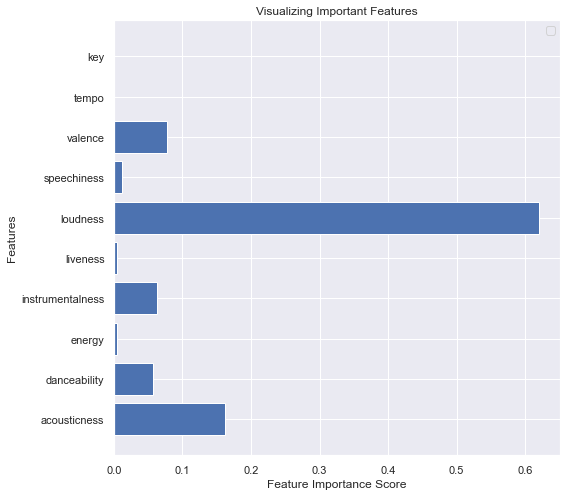

In [15]:
# Create a function to plot feature importances
def plot_feature_importances(model):
    sns.set(style="darkgrid")
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Visualizing Important Features")
    plt.legend()

plot_feature_importances(dtree_clf)

### Model Performance

#### Make predictons

In [16]:
pred = dtree_clf.predict(X_test)

#### Confusion Matrix and Classification Report

In [17]:
# Create a confusion matrix for testing dataset
cf = confusion_matrix(y_test, pred, normalize='true').round(3)
cf

array([[0.915, 0.085],
       [0.581, 0.419]])

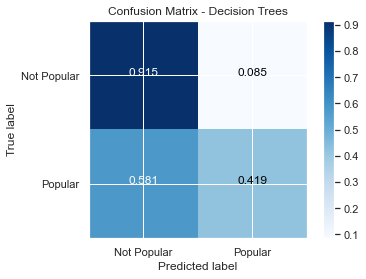

In [18]:
# display confusion matrix

plt.imshow(cf, cmap=plt.cm.Blues) 

# Add titles 
plt.title('Confusion Matrix - Decision Trees')
plt.ylabel('True label')
plt.xlabel('Predicted label')

# scale axis'
class_names = ['Not Popular', 'Popular'] 
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)


thresh = cf.max() / 2. 

for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], 
                 horizontalalignment='center',
                 color='white' if cf[i, j] > thresh else 'black')

plt.colorbar()
plt.show()

In [19]:
# Create a classification report to display evaluation metrics
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88     32944
           1       0.59      0.42      0.49      9720

    accuracy                           0.80     42664
   macro avg       0.72      0.67      0.68     42664
weighted avg       0.79      0.80      0.79     42664



In [20]:
print("Testing Accuracy for Decision Tree Classifier: {:.4}%".format(accuracy_score(y_test, pred) * 100))

Testing Accuracy for Decision Tree Classifier: 80.22%


***
## Model 2: Decision Trees with Bagging
***

In [21]:
# Instantiate a BaggingClassifier
bagged_tree =  BaggingClassifier(DecisionTreeClassifier(criterion='gini', 
                                                        max_depth=5), 
                                                        n_estimators=20)

### Fit to the training data

In [22]:
bagged_tree.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
                  n_estimators=20)

### Make Predictions

In [23]:
pred = bagged_tree.predict(X_test)

### Confusion Matrix and Classification Report

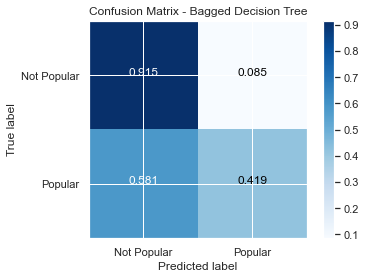

In [24]:
# display confusion matrix
plt.imshow(cf, cmap=plt.cm.Blues) 

# Add titles 
plt.title('Confusion Matrix - Bagged Decision Tree')
plt.ylabel('True label')
plt.xlabel('Predicted label')

# scale axis'
class_names = ['Not Popular', 'Popular'] 
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)


thresh = cf.max() / 2. 

for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], 
                 horizontalalignment='center',
                 color='white' if cf[i, j] > thresh else 'black')

plt.colorbar()
plt.show()

In [25]:
# Create a classification report to display evaluation metrics
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88     32944
           1       0.61      0.40      0.49      9720

    accuracy                           0.81     42664
   macro avg       0.73      0.66      0.68     42664
weighted avg       0.79      0.81      0.79     42664



### Accuracy Scores

In [26]:
# Training accuracy score
print("Training Accuracy Score: {:.4}%".format(bagged_tree.score(X_train, y_train) * 100))

Training Accuracy Score: 80.47%


In [27]:
# Test accuracy score
print("Testing Accuracy Score: {:.4}%".format(bagged_tree.score(X_test, y_test) * 100))

Testing Accuracy Score: 80.57%


***
## Model 3: Baseline RandomForestClassifier Model
***

### Instantiate and fit a RandomForestClassifier

In [28]:
forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=5)

### Make predictions

In [29]:
pred = forest.predict(X_test)

### Accuracy Scores

In [30]:
# Training accuracy score
print("Training Accuracy Score: {:.4}%".format(forest.score(X_train, y_train) * 100))

Training Accuracy Score: 80.35%


In [31]:
# Test accuracy score
print("Testing Accuracy Score: {:.4}%".format(forest.score(X_test, y_test) * 100))

Testing Accuracy Score: 80.39%


In [32]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, pred))

Accuracy: 0.8039096193512094


### Confusion Matrix & Classification Report

In [33]:
# Create a confusion matrix for testing dataset
cf = confusion_matrix(y_test, pred, normalize='true').round(3)
cf

array([[0.961, 0.039],
       [0.729, 0.271]])

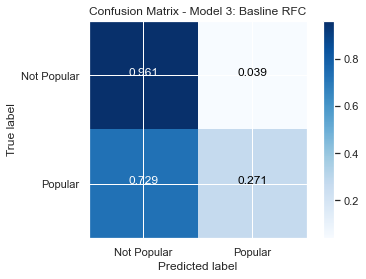

In [34]:
plt.imshow(cf, cmap=plt.cm.Blues) 

# Add titles 
plt.title('Confusion Matrix - Model 3: Basline RFC')
plt.ylabel('True label')
plt.xlabel('Predicted label')

# scale axis'
class_names = ['Not Popular', 'Popular'] 
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)


thresh = cf.max() / 2. 

for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], 
                 horizontalalignment='center',
                 color='white' if cf[i, j] > thresh else 'black')

plt.colorbar()
plt.show()

In [35]:
# Create a classification report to display evaluation metrics
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.82      0.96      0.88     32944
           1       0.67      0.27      0.39      9720

    accuracy                           0.80     42664
   macro avg       0.75      0.62      0.63     42664
weighted avg       0.78      0.80      0.77     42664



### Plot Feature Importance

In [36]:
feature_imp = pd.Series(forest.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp

loudness            0.448236
acousticness        0.234556
instrumentalness    0.090888
energy              0.090616
valence             0.052655
danceability        0.051349
speechiness         0.018754
liveness            0.010569
tempo               0.002283
key                 0.000094
dtype: float64

No handles with labels found to put in legend.


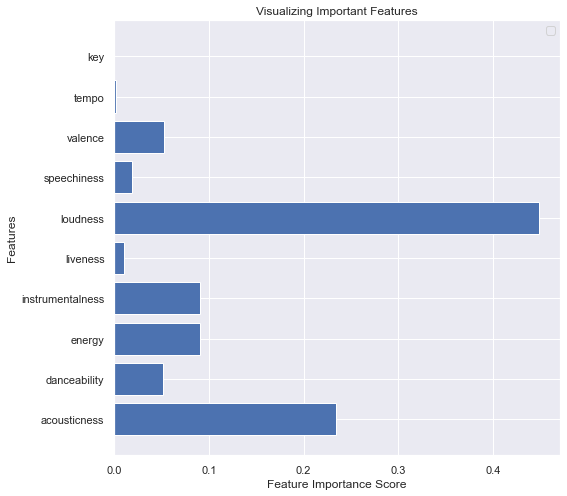

In [37]:
plot_feature_importances(forest)

***
## Model 4: Baseline RandomForestClassifier Model with only important features
***

In [38]:
# Taking another look at the feature importances
feature_imp = pd.Series(forest.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp

loudness            0.448236
acousticness        0.234556
instrumentalness    0.090888
energy              0.090616
valence             0.052655
danceability        0.051349
speechiness         0.018754
liveness            0.010569
tempo               0.002283
key                 0.000094
dtype: float64

### Define X and y

In [39]:
y = df['popular']
X = df[['acousticness', 'loudness', 'energy', 'speechiness']] 
# only using the 4 most important features

### Train Test Split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.25, 
                                                    random_state=42)

In [41]:
print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)
print('X_test Shape:', X_test.shape)
print('y_test Shape:', y_test.shape)

X_train Shape: (127989, 4)
y_train Shape: (127989,)
X_test Shape: (42664, 4)
y_test Shape: (42664,)


### Instantiate and fit a RandomForestClassifier

In [42]:
rforest = RandomForestClassifier(n_estimators=100, max_depth= 5)
rforest.fit(X_train, y_train)

RandomForestClassifier(max_depth=5)

### Make predictions

In [43]:
pred = rforest.predict(X_test)

### Accuracy Scores

In [44]:
# Training accuracy score
print("Training Accuracy Score: {:.4}%".format(rforest.score(X_train, y_train) * 100))

Training Accuracy Score: 79.77%


In [45]:
# Test accuracy score
print("Testing Accuracy Score: {:.4}%".format(rforest.score(X_test, y_test) * 100))

Testing Accuracy Score: 79.77%


In [46]:
print("Accuracy:",metrics.accuracy_score(y_test, pred))

Accuracy: 0.7976982936433528


### Confusion Matrix and Classification Report

In [47]:
# Create a confusion matrix for testing dataset
cf = confusion_matrix(y_test, pred, normalize='true').round(3)
cf

array([[0.946, 0.054],
       [0.705, 0.295]])

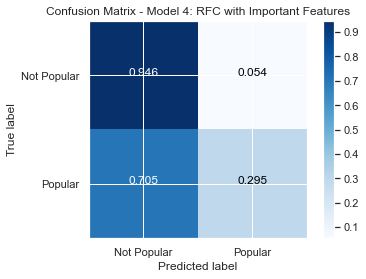

In [48]:
plt.imshow(cf, cmap=plt.cm.Blues) 

# Add titles 
plt.title('Confusion Matrix - Model 4: RFC with Important Features')
plt.ylabel('True label')
plt.xlabel('Predicted label')

# scale axis'
class_names = ['Not Popular', 'Popular'] 
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)


thresh = cf.max() / 2. 

for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], 
                 horizontalalignment='center',
                 color='white' if cf[i, j] > thresh else 'black')

plt.colorbar()
plt.show()

***
## Model 5: RandomForestClassifier with less depth and n_estimators
***

### Define X and y and Train Test Split

In [49]:
y = df['popular']
X = df.drop(['popular'], axis=1)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.25, 
                                                    random_state=42)

In [51]:
print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)
print('X_test Shape:', X_test.shape)
print('y_test Shape:', y_test.shape)

X_train Shape: (127989, 10)
y_train Shape: (127989,)
X_test Shape: (42664, 10)
y_test Shape: (42664,)


### Instantiate and fit a RandomForestClassifier

In [52]:
forest_2 = RandomForestClassifier(n_estimators = 5, max_features= 10, max_depth= 2)
forest_2.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, max_features=10, n_estimators=5)

### Make Predictions

In [53]:
pred = forest_2.predict(X_test)

### Accuracy Scores

In [54]:
# Training accuracy score
print("Training Accuracy Score: {:.4}%".format(forest_2.score(X_train, y_train) * 100))

Training Accuracy Score: 77.3%


In [55]:
# Test accuracy score
print("Testing Accuracy Score: {:.4}%".format(forest_2.score(X_test, y_test) * 100))

Testing Accuracy Score: 77.22%


In [56]:
print("Accuracy:",metrics.accuracy_score(y_test, pred))

Accuracy: 0.7721732608288018


### Confusion Matrix and Classification Report

In [57]:
# Create a confusion matrix for testing dataset
cf = confusion_matrix(y_test, pred, normalize='true').round(3)
cf

array([[1., 0.],
       [1., 0.]])

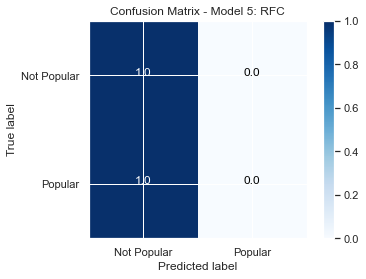

In [58]:
plt.imshow(cf, cmap=plt.cm.Blues) 

# Add titles 
plt.title('Confusion Matrix - Model 5: RFC')
plt.ylabel('True label')
plt.xlabel('Predicted label')

# scale axis'
class_names = ['Not Popular', 'Popular'] 
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)


thresh = cf.max() / 2. 

for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], 
                 horizontalalignment='center',
                 color='white' if cf[i, j] > thresh else 'black')

plt.colorbar()
plt.show()

### Plot Feature Importance

In [59]:
feature_imp = pd.Series(forest_2.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp

loudness            0.792508
acousticness        0.207492
key                 0.000000
tempo               0.000000
valence             0.000000
speechiness         0.000000
liveness            0.000000
instrumentalness    0.000000
energy              0.000000
danceability        0.000000
dtype: float64

No handles with labels found to put in legend.


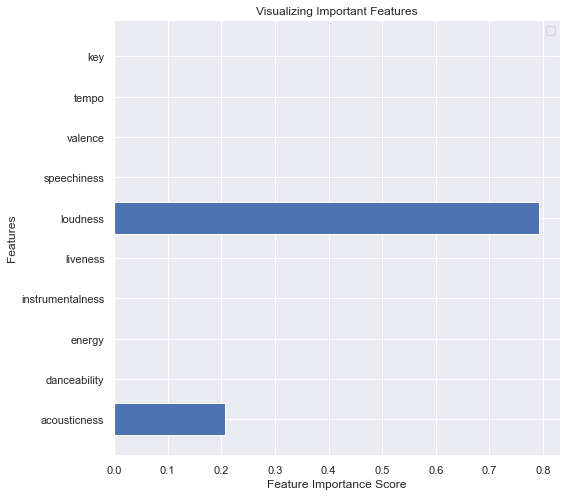

In [60]:
plot_feature_importances(forest_2)

***
## Model 6: RandomForestClassifier with less depth and n_estimators and important features
***

### Define X and y

In [61]:
y = df['popular']
X = df[['acousticness', 'loudness']]
# only using the 2 most important features

### Train Test Split

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.25, 
                                                    random_state=42)

In [63]:
print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)
print('X_test Shape:', X_test.shape)
print('y_test Shape:', y_test.shape)

X_train Shape: (127989, 2)
y_train Shape: (127989,)
X_test Shape: (42664, 2)
y_test Shape: (42664,)


### Instantiate and fit a RandomForestClassifier

In [64]:
rforest_2 = RandomForestClassifier(n_estimators = 5, max_depth= 2)
rforest_2.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, n_estimators=5)

### Make Predictions

In [65]:
pred = rforest_2.predict(X_test)

### Accuracy Scores

In [66]:
# Training accuracy score
print("Training Accuracy Score: {:.4}%".format(rforest_2.score(X_train, y_train) * 100))

# Test accuracy score
print("Testing Accuracy Score: {:.4}%".format(rforest_2.score(X_test, y_test) * 100))

print("Accuracy:",metrics.accuracy_score(y_test, pred))

Training Accuracy Score: 77.3%
Testing Accuracy Score: 77.22%
Accuracy: 0.7721732608288018


### Confusion Matrix and Classification Report

In [67]:
# Create a confusion matrix for testing dataset
cf = confusion_matrix(y_test, pred, normalize='true').round(3)
cf

array([[1., 0.],
       [1., 0.]])

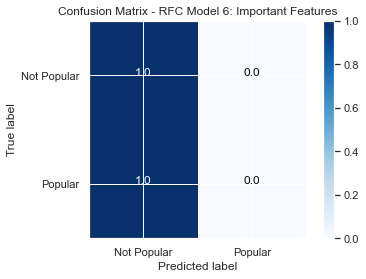

In [68]:
plt.imshow(cf, cmap=plt.cm.Blues) 

# Add titles 
plt.title('Confusion Matrix - RFC Model 6: Important Features')
plt.ylabel('True label')
plt.xlabel('Predicted label')

# scale axis'
class_names = ['Not Popular', 'Popular'] 
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)


thresh = cf.max() / 2. 

for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], 
                 horizontalalignment='center',
                 color='white' if cf[i, j] > thresh else 'black')

plt.colorbar()
plt.show()

***
## Model 7: Baseline RandomForestRegressor 
***

### Make df with necessary info

In [69]:
# # df = raw_df[['acousticness', 'danceability', 'energy', 
#           'instrumentalness', 'liveness', 'loudness', 
#           'speechiness', 'valence', 'tempo', 'key', 'popularity']]

In [70]:
# df.head()

### Define X and y

In [71]:
# y = np.array(df['popularity'])
# X = np.array(df.drop(['popularity'], axis=1))

### Train Test Split

In [72]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, 
#                                                     test_size = 0.25, 
#                                                     random_state=42)

In [73]:
# print('X_train Shape:', X_train.shape)
# print('y_train Shape:', y_train.shape)
# print('X_test Shape:', X_test.shape)
# print('y_test Shape:', y_test.shape)

### Instantiate and fit a RandomForestRegressor

In [74]:
#rf = RandomForestRegressor(n_estimators= 1000, max_depth= 5)

In [75]:
#rf.fit(X_train, y_train)

### Make Predictions

In [76]:
# pred = rf.predict(X_test)

### Accuracy Scores

In [77]:
# # Calculate the absolute errors
# errors = abs(pred - y_test)

# # Print out the mean absolute error (mae)
# print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# # Calculate mean absolute percentage error (MAPE)
# mape = 100 * (errors / y_test)

# # Calculate and display accuracy
# accuracy = 100 - np.mean(mape)
# print('Accuracy:', round(accuracy, 2), '%.')

### Plot Feature Importance

In [78]:
#plot_feature_importances(rf)